In [44]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.linkedin.com/jobs/search/?keywords=Data%20Analyst&location=India'
headers = {'User-Agent': 'Mozilla/5.0'}

response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.text, 'html.parser')

job_data = []
for job_card in soup.find_all('div', class_='base-card'):
    try:
        title = job_card.find('h3', class_='base-search-card__title').get_text(strip=True)
        company = job_card.find('h4', class_='base-search-card__subtitle').get_text(strip=True)
        location = job_card.find('span', class_='job-search-card__location').get_text(strip=True)
        job_url = job_card.find('a', class_='base-card__full-link')['href']

        job_data.append({
            'Title': title,
            'Company': company,
            'Location': location,
            'Job_URL': job_url
        })
    except AttributeError:
        continue

df = pd.DataFrame(job_data)
print(df.head())
df.to_csv('linkedin_jobs_raw.csv', index=False)

          Title           Company                           Location  \
0  Data Analyst           Infosys   Bengaluru East, Karnataka, India   
1  Data Analyst  American Express           Gurugram, Haryana, India   
2  Data Analyst           Infosys   Bengaluru East, Karnataka, India   
3  Data Analyst       LTIMindtree  Bangalore Rural, Karnataka, India   
4  Data Analyst         Media.net        Bengaluru, Karnataka, India   

                                             Job_URL  
0  https://in.linkedin.com/jobs/view/data-analyst...  
1  https://in.linkedin.com/jobs/view/data-analyst...  
2  https://in.linkedin.com/jobs/view/data-analyst...  
3  https://in.linkedin.com/jobs/view/data-analyst...  
4  https://in.linkedin.com/jobs/view/data-analyst...  


In [60]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
import time

# --- Replace with your LinkedIn credentials ---
LINKEDIN_EMAIL = 'nagarajdevaki2@gmail.com'
LINKEDIN_PASSWORD = 'Yourpassword'

# Skills to extract
skills_list = [
    'Python','R', 'SQL', 'Excel', 'Power BI', 'Tableau', 'Machine Learning',
    'Deep Learning', 'Azure', 'AWS', 'Spark', 'Pandas', 'Numpy', 'Scikit-learn',
    'Data Analysis', 'Data Visualization', 'Statistics', 'ETL', 'BigQuery',
    'Java', 'Hadoop', 'Snowflake', 'Looker', 'Kubernetes', 'Docker','Big Data'
]

def extract_skills(text, skills):
    if not isinstance(text, str):
        return []
    text = text.lower()
    return list({skill for skill in skills if skill.lower() in text})

# Load your dataset
df = pd.read_csv('linkedin_jobs_raw.csv')

# Setup browser
options = Options()
options.add_argument('--disable-blink-features=AutomationControlled')
chromedriver_path = r'C:\Users\Admin\Downloads\chromedriver-win64\chromedriver.exe'
driver = webdriver.Chrome(service=Service(r'C:\Users\Admin\Downloads\chromedriver-win64\chromedriver-win64\chromedriver.exe'), options=options)

# --- Login to LinkedIn ---
driver.get("https://www.linkedin.com/login")
WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'username')))
driver.find_element(By.ID, 'username').send_keys(LINKEDIN_EMAIL)
driver.find_element(By.ID, 'password').send_keys(LINKEDIN_PASSWORD)
driver.find_element(By.XPATH, "//button[@type='submit']").click()

time.sleep(3)  # wait for login to complete

# --- Scrape job descriptions ---
job_descriptions = []
extracted_skills = []

for i, url in enumerate(df['Job_URL']):
    print(f"[{i+1}/{len(df)}] Scraping: {url}")
    try:
        driver.get(url)
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, 'description__text'))
        )

        try:
            desc = driver.find_element(By.CLASS_NAME, 'description__text').text
        except:
            try:
                desc = driver.find_element(By.CLASS_NAME, 'show-more-less-html__markup').text
            except:
                desc = 'Not Found'

        job_descriptions.append(desc)
        extracted_skills.append(extract_skills(desc, skills_list))
    except Exception as e:
        print(f"Failed on {url} -> {e}")
        job_descriptions.append("Not Found")
        extracted_skills.append([])
             
driver.quit()

# Save results
df['Job_Description'] = job_descriptions
df['Extracted_Skills'] = extracted_skills
df.to_csv('linkedin_jobs_loggedin.csv', index=False)
print("\n✅ Done. Saved to linkedin_jobs_loggedin.csv")


[1/60] Scraping: https://in.linkedin.com/jobs/view/data-analyst-at-infosys-4202701257?position=1&pageNum=0&refId=vnawdSMyVxWcq%2Baz5hTL0A%3D%3D&trackingId=jGXb03ZTngQqDZikWvDsZg%3D%3D
[2/60] Scraping: https://in.linkedin.com/jobs/view/data-analyst-at-american-express-4205664890?position=2&pageNum=0&refId=vnawdSMyVxWcq%2Baz5hTL0A%3D%3D&trackingId=LZnxiEgkxmjYyDHdd7XCHA%3D%3D
[3/60] Scraping: https://in.linkedin.com/jobs/view/data-analyst-at-infosys-4207552838?position=3&pageNum=0&refId=vnawdSMyVxWcq%2Baz5hTL0A%3D%3D&trackingId=zUzGqNGNt45kTPz%2B5b3x2Q%3D%3D
[4/60] Scraping: https://in.linkedin.com/jobs/view/data-analyst-at-ltimindtree-4207304045?position=4&pageNum=0&refId=vnawdSMyVxWcq%2Baz5hTL0A%3D%3D&trackingId=XMkh6c6T5%2BIyQp6kblwmJQ%3D%3D
[5/60] Scraping: https://in.linkedin.com/jobs/view/data-analyst-at-media-net-4204760326?position=5&pageNum=0&refId=vnawdSMyVxWcq%2Baz5hTL0A%3D%3D&trackingId=Lvn2KX3%2FQWuy%2BsfZb6jH1w%3D%3D
[6/60] Scraping: https://in.linkedin.com/jobs/view/analyt

In [93]:

# Flatten skill lists
df['Skills_Combined'] = df['Extracted_Skills'].apply(lambda x: [s.strip().title() for s in x if isinstance(s, str)])

# Create one row per skill (explode)
df_exploded = df[['Title', 'Location', 'Skills_Combined']].explode('Skills_Combined')
df_exploded = df_exploded.rename(columns={'Skills_Combined': 'Skill'})

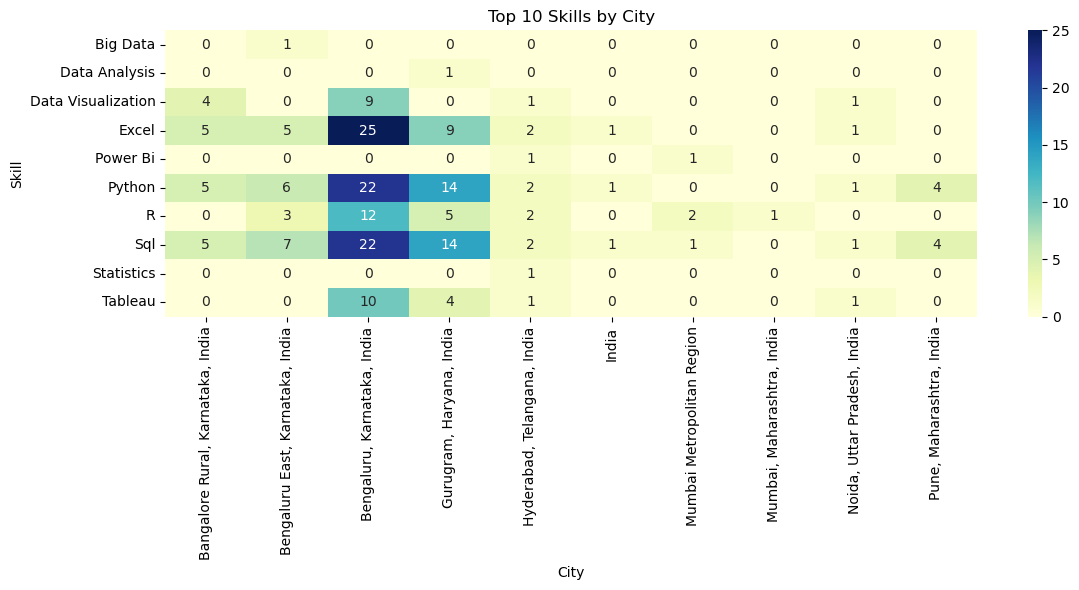

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by city & skill
city_skill_counts = df_exploded.groupby(['Location', 'Skill']).size().reset_index(name='Count')

# Top 10 skills overall
top_skills = city_skill_counts.groupby('Skill')['Count'].sum().nlargest(10).index.tolist()
filtered = city_skill_counts[city_skill_counts['Skill'].isin(top_skills)]

# Pivot for heatmap
pivot_table = filtered.pivot_table(index='Skill', columns='Location', values='Count', fill_value=0)

# Plot
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap='YlGnBu')
plt.title("Top 10 Skills by City")
plt.ylabel("Skill")
plt.xlabel("City")
plt.tight_layout()
plt.show()